In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.preprocessing import label_binarize

2025-05-21 22:56:05.247649: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747846565.259921   11810 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747846565.263611   11810 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747846565.273137   11810 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747846565.273151   11810 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747846565.273153   11810 computation_placer.cc:177] computation placer alr

In [2]:
train_path= '/home/nemo/Documents/Coding/AI/Retinal_OCT/dataset/train'
val_path='/home/nemo/Documents/Coding/AI/Retinal_OCT/dataset/val'
test_path='/home/nemo/Documents/Coding/AI/Retinal_OCT/dataset/test'

In [32]:
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)
val_datagen= image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)
test_datagen= image.ImageDataGenerator()

In [33]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (224,224),
    batch_size = 8,
    shuffle=True,
    class_mode = 'categorical')
validation_generator = val_datagen.flow_from_directory(
    val_path,
    target_size = (224,224),
    batch_size = 8,
    shuffle=False,
    class_mode = 'categorical')
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size = (224,224),
    batch_size = 8,
    shuffle=False,
    class_mode = 'categorical'
)

Found 20263 images belonging to 8 classes.
Found 2540 images belonging to 8 classes.
Found 2557 images belonging to 8 classes.


In [5]:
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)
print(class_names)

['AMD', 'CNV', 'CSR', 'DME', 'DR', 'DRUSEN', 'MH', 'NORMAL']


In [6]:
image_size = (224, 224)
batch_size = 8

# Function to load and preprocess images
def load_and_preprocess_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_size)
    img = tf.image.convert_image_dtype(img, tf.float32) / 255.0
    return img

# Function to get image paths and labels from a directory
def get_image_paths_and_labels(data_dir):
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(data_dir))
    class_indices = {class_name: i for i, class_name in enumerate(class_names)}
    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        for filename in os.listdir(class_path):
            if filename.endswith(('.jpg', '.jpeg', '.png')):  # Adjust based on your file types
                image_paths.append(os.path.join(class_path, filename))
                labels.append(class_indices[class_name])
    return image_paths, tf.one_hot(labels, depth=len(class_names)) # One-hot encode labels

# Create training dataset
train_image_paths, train_labels = get_image_paths_and_labels(train_path)
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))
train_dataset = train_dataset.map(lambda path, label: (load_and_preprocess_image(path), label),
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=len(train_image_paths))
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Create validation dataset
validation_image_paths, validation_labels = get_image_paths_and_labels(test_path)
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_image_paths, validation_labels))
validation_dataset = validation_dataset.map(lambda path, label: (load_and_preprocess_image(path), label),
                                           num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(batch_size)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

I0000 00:00:1747846567.280704   11810 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5524 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050, pci bus id: 0000:01:00.0, compute capability: 8.6


In [7]:
from tensorflow.keras import Sequential, layers

# Load the pre-trained EfficientNetB3 model (excluding the top classification layer)
base_model = tf.keras.applications.EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = True

# Create a new sequential model
model = Sequential()

# Add the EfficientNetB3 base model
model.add(base_model)

# Add the convolutional layers you defined
# model.add(layers.Conv2D(filters=8, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPool2D(pool_size=(3, 3)))

model.add(layers.Flatten())
model.add(layers.Dense(8, activation='softmax'))

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 7, 7, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 75264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │       602,120 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,385,655 (43.43 MB)

 Trainable params: 11,298,352 (43.10 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy','Precision','Recall','AUC'])

In [9]:
history = model.fit(
    train_generator,
    epochs=50,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto')],
    validation_data=validation_generator
    )

/home/nemo/.conda/envs/tf/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1747846605.648466   11978 service.cc:152] XLA service 0x705578005ad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747846605.648480   11978 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
2025-05-21 22:56:46.838338: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747846611.868042   11978 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747846662.036710   11978 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


634/634 ━━━━━━━━━━━━━━━━━━━━ 332s 382ms/step - AUC: 0.9255 - Precision: 0.7632 - Recall: 0.7419 - accuracy: 0.7496 - loss: 1.4172 - val_AUC: 0.9249 - val_Precision: 0.7925 - val_Recall: 0.7862 - val_accuracy: 0.7898 - val_loss: 1.7210 - learning_rate: 0.0010
Epoch 2/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 173s 272ms/step - AUC: 0.9701 - Precision: 0.8833 - Recall: 0.8759 - accuracy: 0.8795 - loss: 0.6944 - val_AUC: 0.9884 - val_Precision: 0.9307 - val_Recall: 0.9252 - val_accuracy: 0.9283 - val_loss: 0.2925 - learning_rate: 0.0010
Epoch 3/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 173s 273ms/step - AUC: 0.9816 - Precision: 0.9111 - Recall: 0.9059 - accuracy: 0.9081 - loss: 0.4485 - val_AUC: 0.9666 - val_Precision: 0.8674 - val_Recall: 0.8472 - val_accuracy: 0.8563 - val_loss: 0.7456 - learning_rate: 0.0010
Epoch 4/50
634/634 ━━━━━━━━━━━━━━━━━━━━ 177s 278ms/step - AUC: 0.9791 - Precision: 0.9047 - Recall: 0.8983 - accuracy: 0.9011 - loss: 0.5124 - val_AUC: 0.9829 - val_Precision: 0.9249 - val_Recall: 0.91

In [31]:
model.save('all_models/EfficientNetB3_2.keras')

In [10]:
model.evaluate(test_generator)

80/80 ━━━━━━━━━━━━━━━━━━━━ 23s 293ms/step - AUC: 0.9984 - Precision: 0.9778 - Recall: 0.9752 - accuracy: 0.9757 - loss: 0.0692


[0.07500358670949936,
 0.9745795726776123,
 0.9772370457649231,
 0.9737974405288696,
 0.9987271428108215]

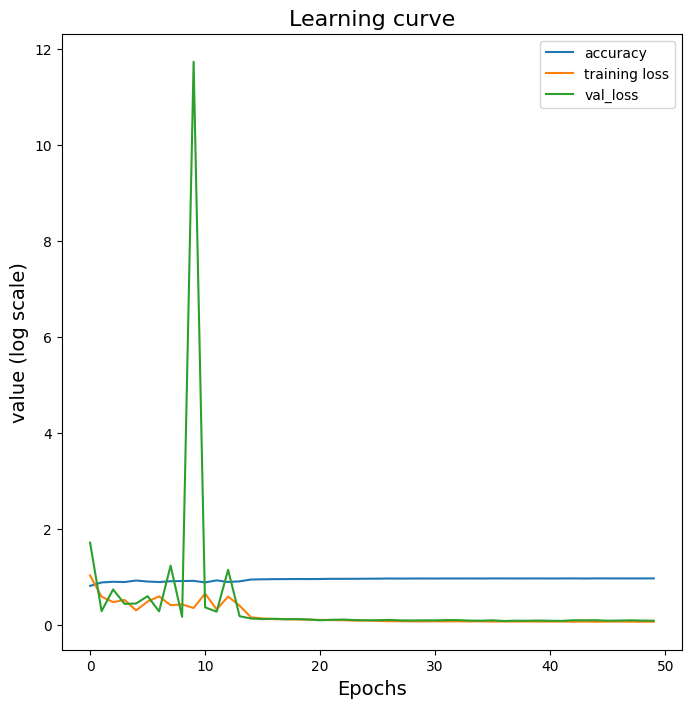

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.title("Learning curve", fontsize=16)
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["loss"], label="training loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("value (log scale)", fontsize=14)
plt.legend()
plt.savefig('learning_curve.pdf')

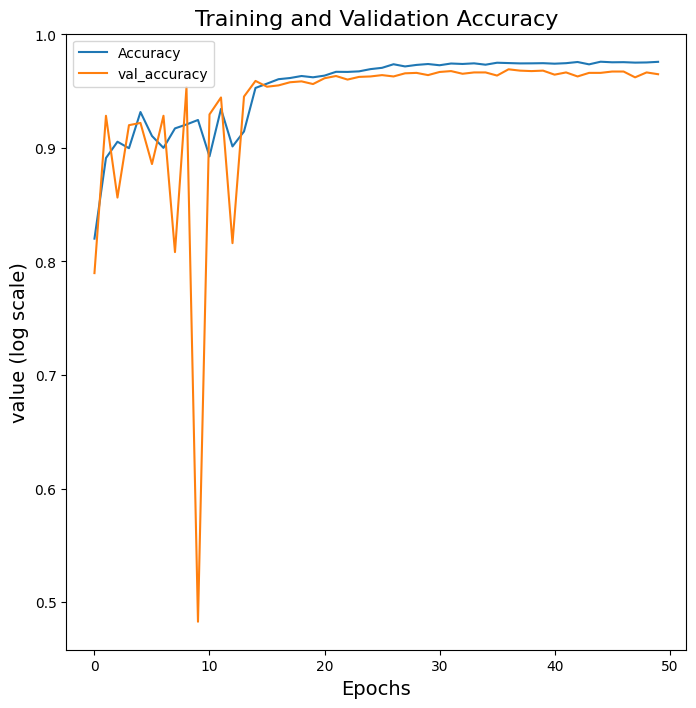

In [12]:
plt.figure(figsize=(8, 8))
plt.title("Training and Validation Accuracy", fontsize=16)
plt.plot(history.history["accuracy"], label="Accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("value (log scale)", fontsize=14)
plt.legend();
plt.savefig('accuracy_curve.pdf')

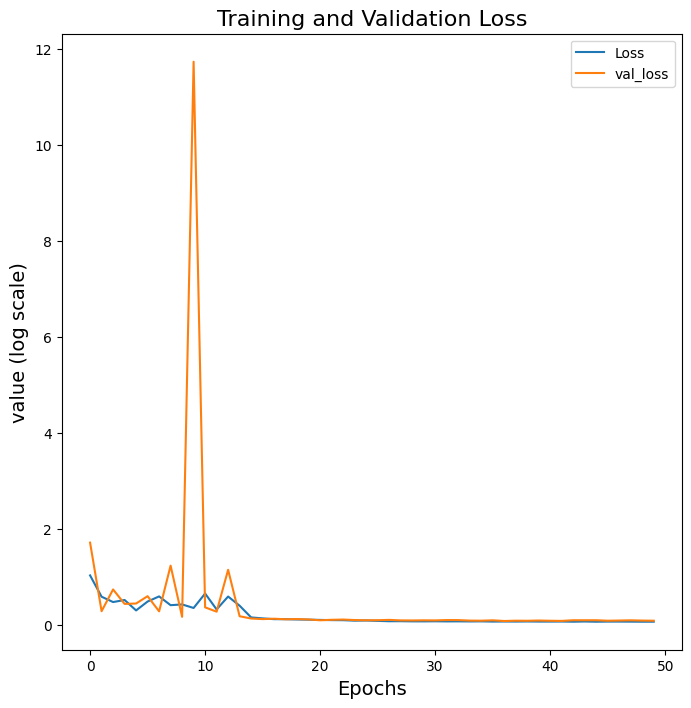

In [13]:
plt.figure(figsize=(8, 8))
plt.title("Training and Validation Loss", fontsize=16)
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("value (log scale)", fontsize=14)
plt.legend();
plt.savefig('loss_curve.pdf')

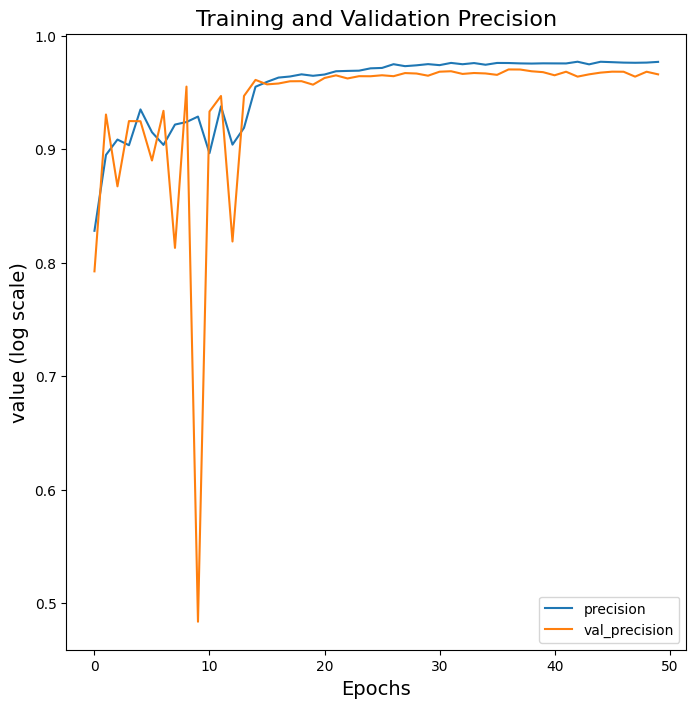

In [14]:
plt.figure(figsize=(8, 8))
plt.title("Training and Validation Precision", fontsize=16)
plt.plot(history.history["Precision"], label="precision")
plt.plot(history.history["val_Precision"], label="val_precision")
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("value (log scale)", fontsize=14)
plt.legend();
plt.savefig('precision_curve.pdf')

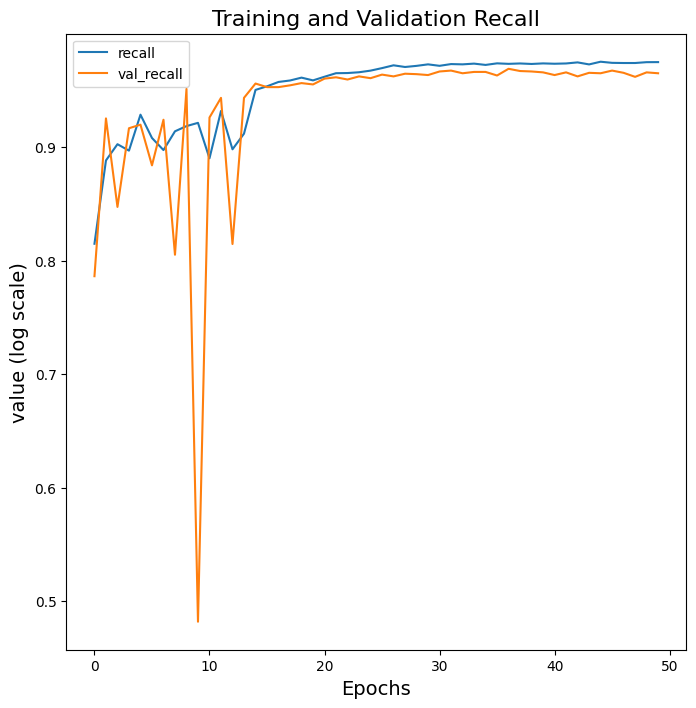

In [15]:
plt.figure(figsize=(8, 8))
plt.title("Training and Validation Recall", fontsize=16)
plt.plot(history.history["Recall"], label="recall")
plt.plot(history.history["val_Recall"], label="val_recall")
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("value (log scale)", fontsize=14)
plt.legend();
plt.savefig('recall_curve.pdf')

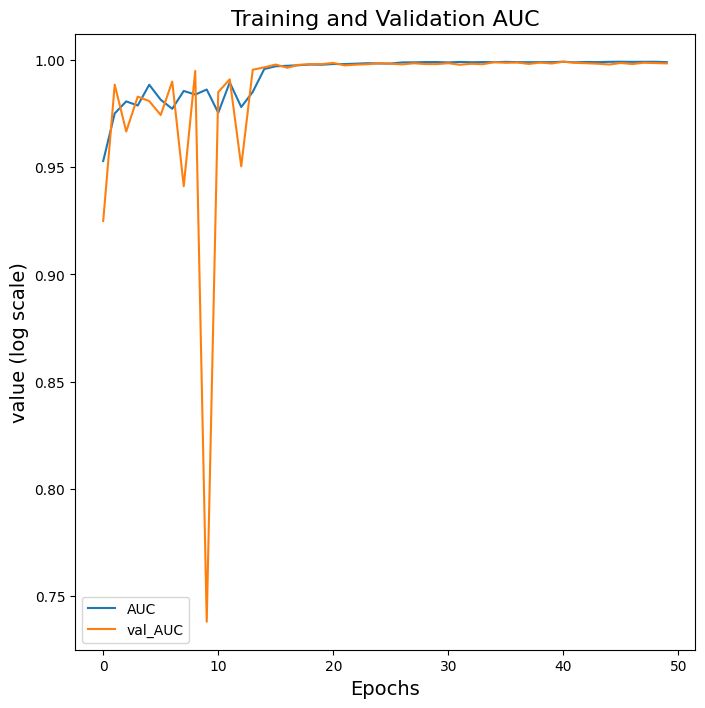

In [16]:
plt.figure(figsize=(8, 8))
plt.title("Training and Validation AUC", fontsize=16)
plt.plot(history.history["AUC"], label="AUC")
plt.plot(history.history["val_AUC"], label="val_AUC")
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("value (log scale)", fontsize=14)
plt.legend();
plt.savefig('auc_curve.pdf')

In [17]:
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step


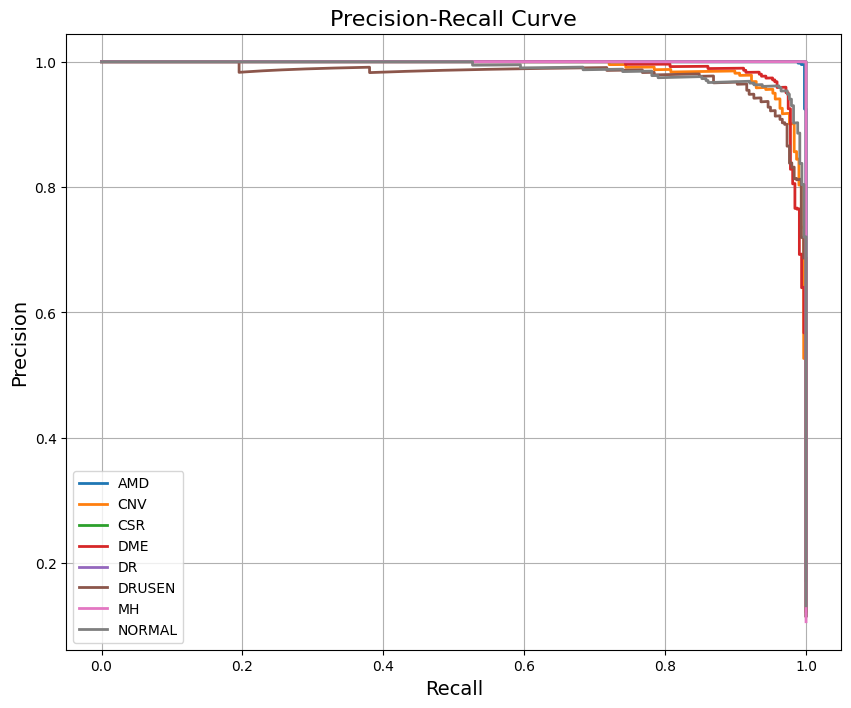

In [18]:
# Binarize true labels
y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))

plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(
        y_true_bin[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, lw=2, label=f'{class_names[i]}')

plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve', fontsize=16)
plt.legend(loc='best')
plt.grid(True)
plt.savefig('precision_recall_curve.pdf')
plt.show()

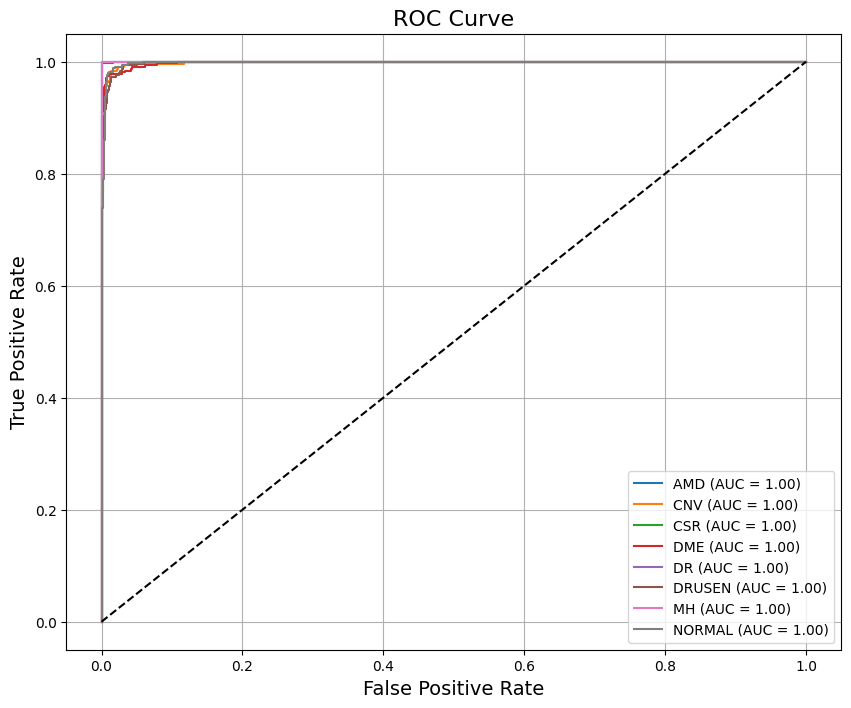

In [19]:
# ROC Curve
y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i],
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc='lower right')
plt.grid()
plt.savefig('roc_curve.pdf')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
[[9.4497925e-26 5.9249453e-29 1.0000000e+00 2.0132455e-41 9.5554075e-29
  1.0750909e-33 1.6421983e-24 3.3981595e-34]]
THE UPLOADED OCT IMAGE IS: CSR


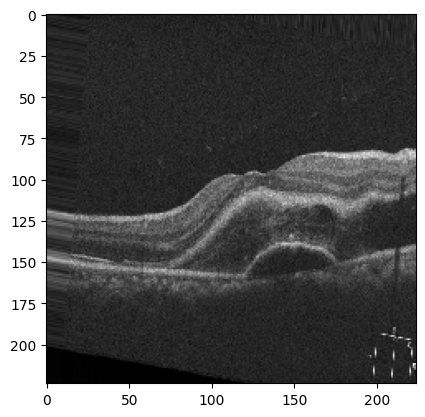

In [20]:
from tensorflow.keras.utils import load_img, img_to_array
img = load_img('/home/nemo/Documents/Coding/AI/Retinal_OCT/dataset/test/CSR/csr_train_2348.jpg',target_size=(224,224))
imag = img_to_array(img)
imaga = np.expand_dims(imag,axis=0) 
ypred = model.predict(imaga)
print(ypred)
a=np.argmax(ypred,axis=1)
if a==0:
      op="AMD"   
elif a==1:
    op='CNV'
elif a==2:
    op='CSR'
elif a==3:
    op='DME'
elif a==4:
    op='DR'
elif a==5:
    op='DRUSEN'
elif a==6:
    op='MH'
else:
      op="Normal"
plt.imshow(img)
print("THE UPLOADED OCT IMAGE IS: "+str(op))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[3.8560789e-02 3.5132402e-06 1.5118861e-08 3.8113233e-04 2.6468389e-10
  9.5995369e-05 1.8996499e-08 9.6095860e-01]]
THE UPLOADED OCT IMAGE IS: Normal


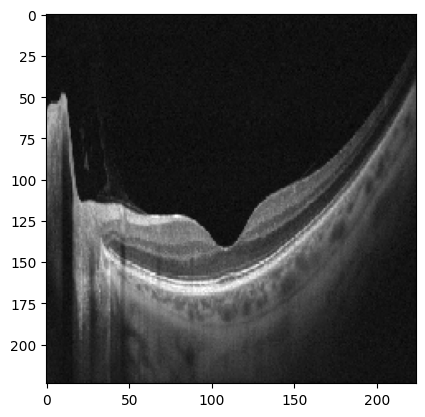

In [21]:
from tensorflow.keras.utils import load_img, img_to_array
img = load_img('/home/nemo/Documents/Coding/AI/Retinal_OCT/dataset/test/NORMAL/no_2497093_3.jpg',target_size=(224,224))
imag = img_to_array(img)
imaga = np.expand_dims(imag,axis=0) 
ypred = model.predict(imaga)
print(ypred)
a=np.argmax(ypred,axis=1)
if a==0:
      op="AMD"   
elif a==1:
    op='CNV'
elif a==2:
    op='CSR'
elif a==3:
    op='DME'
elif a==4:
    op='DR'
elif a==5:
    op='DRUSEN'
elif a==6:
    op='MH'
else:
      op="Normal"
plt.imshow(img)
print("THE UPLOADED OCT IMAGE IS: "+str(op))

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [23]:
# Get true labels
y_true = validation_generator.classes

# Predict probabilities
y_pred_prob = model.predict(validation_generator)

# Convert probabilities to class indices
y_pred = np.argmax(y_pred_prob, axis=1)


80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 259ms/step


In [24]:
class_labels = list(validation_generator.class_indices.keys())

In [25]:
cm = confusion_matrix(y_true, y_pred)

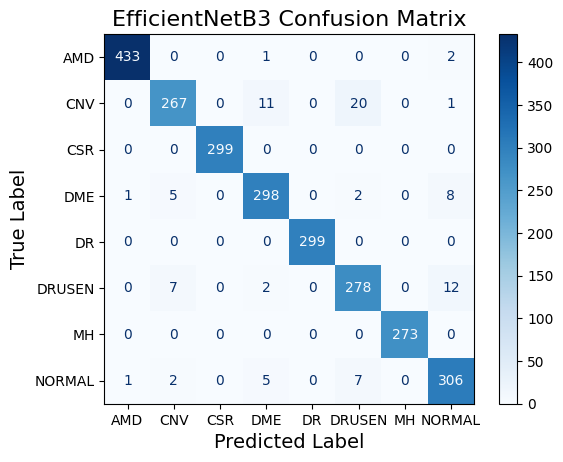

<Figure size 640x480 with 0 Axes>

In [27]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("EfficientNetB3 Confusion Matrix", fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()
plt.savefig('confusion_matrix.pdf')

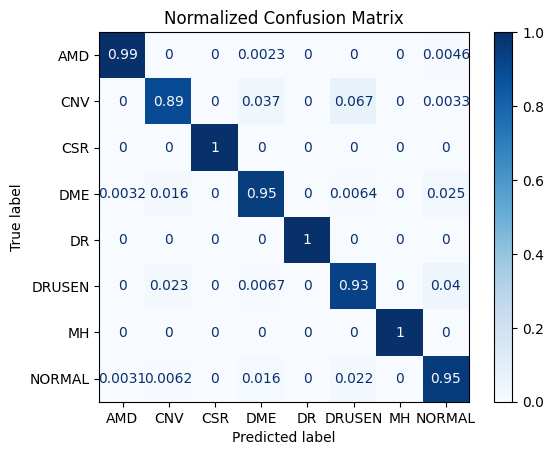

In [28]:
cm_normalized = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Normalized Confusion Matrix")
plt.show()

In [29]:
from sklearn.metrics import classification_report


report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

         AMD       1.00      0.99      0.99       436
         CNV       0.95      0.89      0.92       299
         CSR       1.00      1.00      1.00       299
         DME       0.94      0.95      0.94       314
          DR       1.00      1.00      1.00       299
      DRUSEN       0.91      0.93      0.92       299
          MH       1.00      1.00      1.00       273
      NORMAL       0.93      0.95      0.94       321

    accuracy                           0.97      2540
   macro avg       0.97      0.96      0.96      2540
weighted avg       0.97      0.97      0.97      2540



## Inference Time

In [34]:
import time
import numpy as np

# Assuming 'model' is your trained Keras model
# Assuming 'validation_generator' or a similar data source is available

# --- Prepare your inference data ---
# Get one batch for inference timing.
# Make sure validation_generator is properly initialized and can yield a batch.
# If your generator shuffles, reset it for consistent batch content if needed.
validation_generator.reset()
X_inference_batch, _ = next(validation_generator) # Use next() to get a single batch

print(f"Shape of inference batch: {X_inference_batch.shape}")
print(f"Batch size: {X_inference_batch.shape[0]}")

# --- 1. Warm-up runs (recommended) ---
print("\nPerforming warm-up runs...")
for _ in range(5): # Run 5 warm-up predictions
    _ = model.predict(X_inference_batch, verbose=0)
print("Warm-up complete.")

# --- 2. Measure inference time for a single batch (per step) ---
num_measurements = 100 # Number of times to repeat the measurement for averaging
inference_times_sec_per_step = []

print(f"\nMeasuring inference time over {num_measurements} repetitions...")
for _ in range(num_measurements):
    start_time = time.time()
    _ = model.predict(X_inference_batch, verbose=0) # Set verbose=0 to suppress progress bar
    end_time = time.time()
    inference_times_sec_per_step.append(end_time - start_time)

# Calculate average time per step in seconds
average_inference_time_sec_per_step = np.mean(inference_times_sec_per_step)
std_inference_time_sec_per_step = np.std(inference_times_sec_per_step)

# Convert to milliseconds per step
average_inference_time_ms_per_step = average_inference_time_sec_per_step * 1000
std_inference_time_ms_per_step = std_inference_time_sec_per_step * 1000

print(f"\nAverage inference time per step (batch size {X_inference_batch.shape[0]}):")
print(f"  {average_inference_time_ms_per_step:.4f} ms/step (Std Dev: {std_inference_time_ms_per_step:.4f} ms/step)")

# Optional: Calculate ms/sample if desired
samples_in_batch = X_inference_batch.shape[0]
if samples_in_batch > 0:
    average_inference_time_ms_per_sample = average_inference_time_ms_per_step / samples_in_batch
    print(f"  {average_inference_time_ms_per_sample:.4f} ms/sample")

# --- Example for total inference time over the whole validation set ---
# If you want to know the ms/step for the entire generator, you would need to
# divide the total inference time by the number of steps (batches) in the generator.

print("\nMeasuring total inference time for the entire validation set...")
validation_generator.reset() # Reset generator for a full pass
num_validation_steps = len(validation_generator) # Get the total number of batches

overall_inference_start_time = time.time()
_ = model.predict(validation_generator, verbose=1) # verbose=1 to see progress
overall_inference_end_time = time.time()

total_validation_inference_time_sec = overall_inference_end_time - overall_inference_start_time
total_validation_inference_time_ms = total_validation_inference_time_sec * 1000

# Calculate average ms/step for the entire validation set pass
if num_validation_steps > 0:
    average_ms_per_step_full_pass = total_validation_inference_time_ms / num_validation_steps
    print(f"Total inference time for validation set: {total_validation_inference_time_ms:.2f} ms")
    print(f"Average ms/step over entire validation set ({num_validation_steps} steps): {average_ms_per_step_full_pass:.4f} ms/step")
else:
    print("Validation generator has no steps.")

Shape of inference batch: (8, 224, 224, 3)
Batch size: 8

Performing warm-up runs...
Warm-up complete.

Measuring inference time over 100 repetitions...

Average inference time per step (batch size 8):
  75.0213 ms/step (Std Dev: 3.5344 ms/step)
  9.3777 ms/sample

Measuring total inference time for the entire validation set...


/home/nemo/.conda/envs/tf/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


318/318 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step
Total inference time for validation set: 28628.01 ms
Average ms/step over entire validation set (318 steps): 90.0252 ms/step


In [59]:
history.history.keys()

dict_keys(['AUC', 'Precision', 'Recall', 'accuracy', 'loss', 'val_AUC', 'val_Precision', 'val_Recall', 'val_accuracy', 'val_loss', 'learning_rate'])

In [66]:
history.params

{'verbose': 'auto', 'epochs': 50, 'steps': 634}

In [68]:
print(tf.__version__)

2.19.0


In [70]:
print(tf.keras.__version__)

3.9.2
